# Chest X-Ray Images (Pneumonia)
#### https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
#### Our goal is to identify if someone suffers from pneumonia or not taking into consideration an x-ray of their lungs.

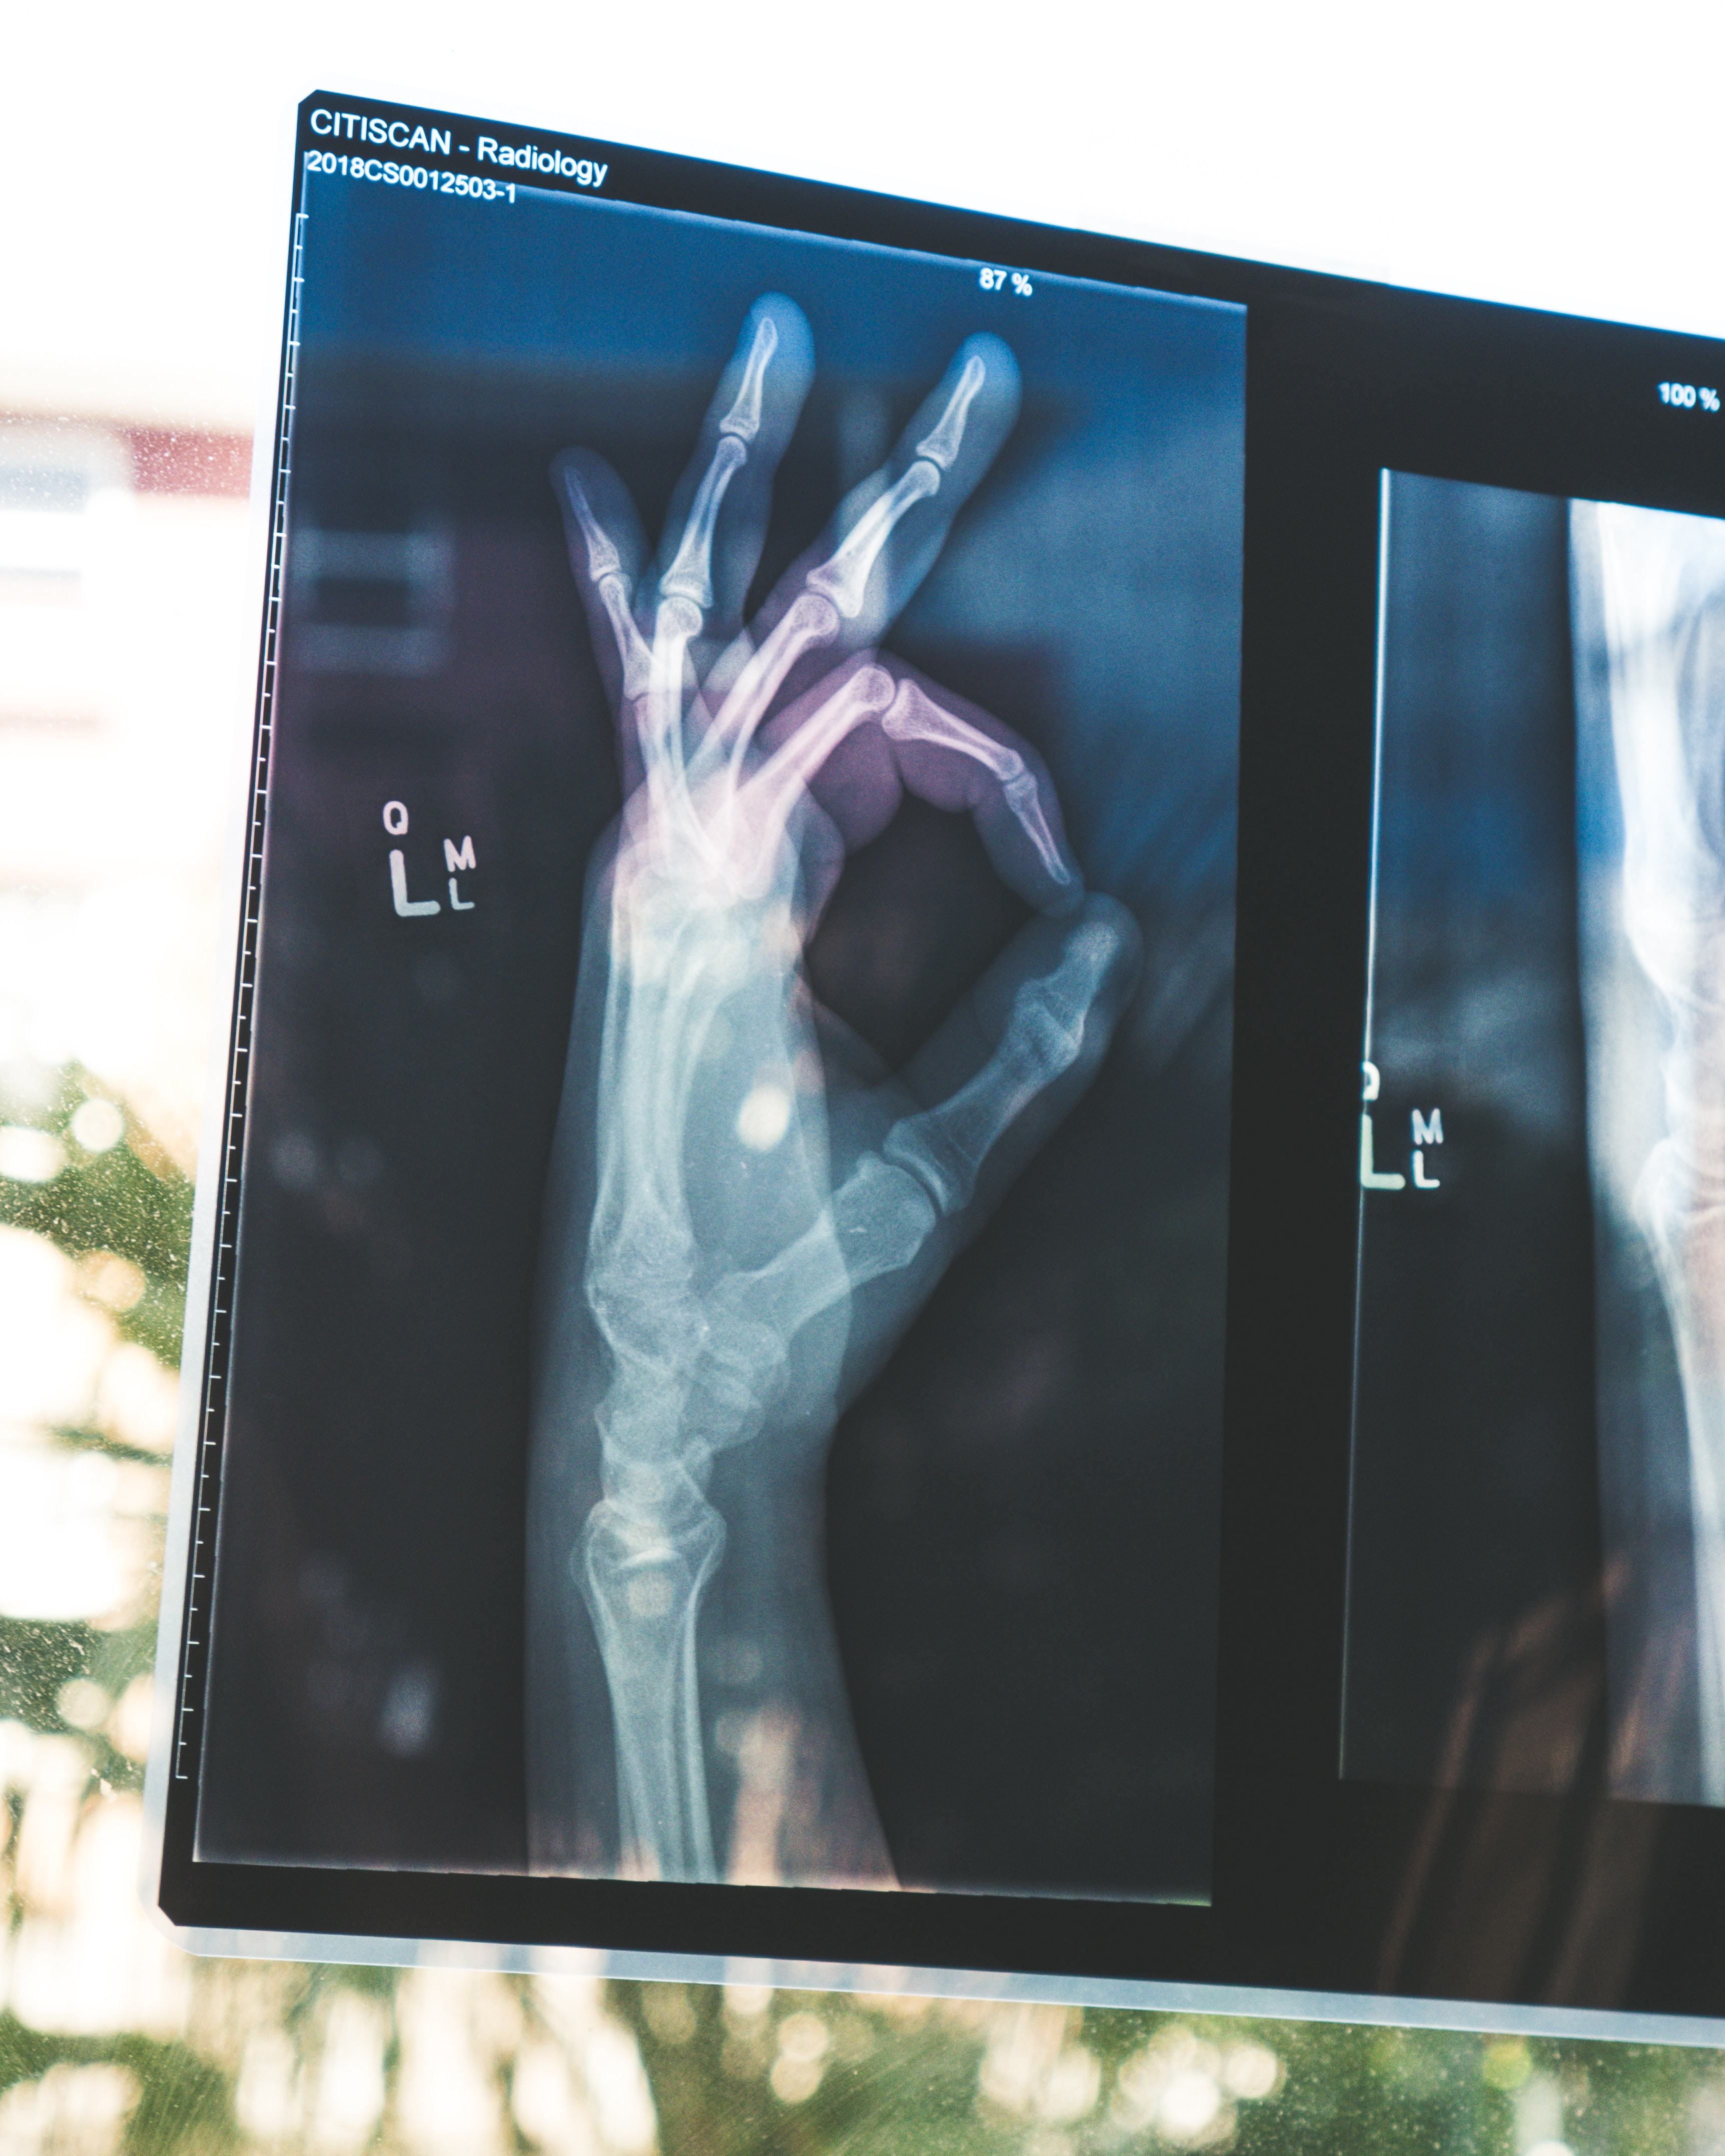

In [78]:
from IPython.display import Image 
pil_img = Image(filename='xray.jpg', 
                width=500,
                height=500)
display(pil_img)

# Project
#### The goal of the project was to recall and reuse skills developed during Coursera's course: "Convolutional Neural Networks in TensorFlow". 
#### The code used in the notebook has been based on the code developed during the course.
#### For this purpose the following Kaggle's use case has been used: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [13]:
# Define the training and validation base directories
train_dir = './data/train'
validation_dir = './data/test' # using test instead of val because of the insufficient number of images for validation

# Directory with training normal pictures
train_normal_dir = os.path.join(train_dir, 'normal')
# Directory with training pneumonia pictures
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')

# Directory with validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'normal')
# Directory with validation pneumonia pictures
validation_pneumonia_dir = os.path.join(validation_dir, 'pneumonia')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_normal_dir))} images of normal lungs for training.\n")
print(f"There are {len(os.listdir(train_pneumonia_dir))} images of pneumonia for training.\n")
print(f"There are {len(os.listdir(validation_normal_dir))} images of normal lungs for validation.\n")
print(f"There are {len(os.listdir(validation_pneumonia_dir))} images of pneumonia for validation.\n")

There are 1341 images of normal lungs for training.

There are 3875 images of pneumonia for training.

There are 234 images of normal lungs for validation.

There are 390 images of pneumonia for validation.



Sample images of infected and healthy lungs
Sample normal lungs:


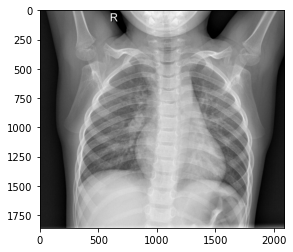

Sample lungs with pneumonia:


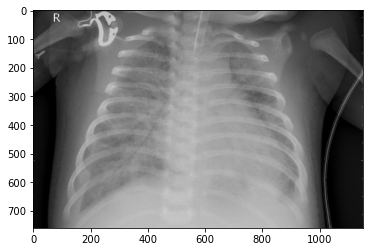

In [17]:
print("Sample images of infected and healthy lungs")
print("Sample normal lungs:")
plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])}"))
plt.show()

print("Sample lungs with pneumonia:")
plt.imshow(load_img(f"{os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[0])}"))
plt.show()

In [21]:
# checking shapes of the images

for i in range(50):
    sample_image  = load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[i])}")

    # Convert the image into its numpy array representation
    sample_array = img_to_array(sample_image)
    
    print(f"The image shape is: {sample_array.shape}")

The image shape is: (1858, 2090, 3)
The image shape is: (1152, 1422, 3)
The image shape is: (1434, 1810, 3)
The image shape is: (1279, 1618, 3)
The image shape is: (1125, 1600, 3)
The image shape is: (1306, 1974, 3)
The image shape is: (1013, 1528, 3)
The image shape is: (1167, 1384, 3)
The image shape is: (1144, 1450, 3)
The image shape is: (993, 1468, 3)
The image shape is: (1581, 1724, 3)
The image shape is: (1044, 1346, 3)
The image shape is: (1237, 1156, 3)
The image shape is: (1453, 1740, 3)
The image shape is: (1928, 2138, 3)
The image shape is: (1156, 1596, 3)
The image shape is: (1974, 2102, 3)
The image shape is: (1152, 1542, 3)
The image shape is: (1156, 1518, 3)
The image shape is: (1133, 1612, 3)
The image shape is: (1438, 1844, 3)
The image shape is: (1209, 1488, 3)
The image shape is: (758, 994, 3)
The image shape is: (1314, 1750, 3)
The image shape is: (1430, 1762, 3)
The image shape is: (808, 1202, 3)
The image shape is: (1719, 1972, 3)
The image shape is: (1187, 1534,

## Training and Validation Generators

In [31]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
        Creates the training and validation data generators

        Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images

        Returns:
        train_generator, validation_generator: tuple containing the generators
    """

    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                       rotation_range=20,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       fill_mode='nearest',
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=64,
                                                        class_mode='binary',
                                                        target_size=(300, 300))

    validation_datagen = ImageDataGenerator(rescale=1.0/255)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode='binary',
                                                                  target_size=(300, 300))
    return train_generator, validation_generator

In [32]:
# Testing the generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 1. My own model

### Iteration 1st

In [33]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer=RMSprop(),
            loss='binary_crossentropy',
            metrics=['accuracy'])

    return model

In [34]:
model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
82/82 [==============================] - 982s 12s/step - loss: 0.7909 - accuracy: 0.7141 - val_loss: 0.6826 - val_accuracy: 0.6378
Epoch 2/15
82/82 [==============================] - 829s 10s/step - loss: 0.4634 - accuracy: 0.8173 - val_loss: 0.7806 - val_accuracy: 0.6619
Epoch 3/15
82/82 [==============================] - 736s 9s/step - loss: 0.3588 - accuracy: 0.8330 - val_loss: 0.8751 - val_accuracy: 0.6619
Epoch 4/15
82/82 [==============================] - 867s 11s/step - loss: 0.3360 - accuracy: 0.8537 - val_loss: 0.5811 - val_accuracy: 0.7821
Epoch 5/15
82/82 [==============================] - 805s 10s/step - loss: 0.3154 - accuracy: 0.8623 - val_loss: 0.6896 - val_accuracy: 0.6683
Epoch 6/15
82/82 [==============================] - 769s 9s/step - loss: 0.2789 - accuracy: 0.8838 - val_loss: 0.4722 - val_accuracy: 0.7772
Epoch 7/15
82/82 [==============================] - 817s 10s/step - loss: 0.2739 - accuracy: 0.8821 - val_loss: 0.4650 - val_accuracy: 0.7708
Epoch 8/

In [42]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

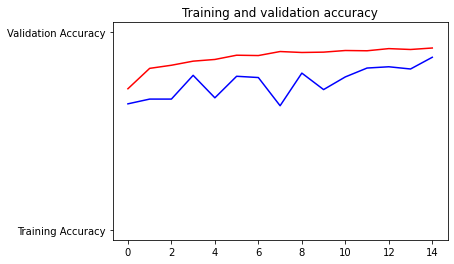

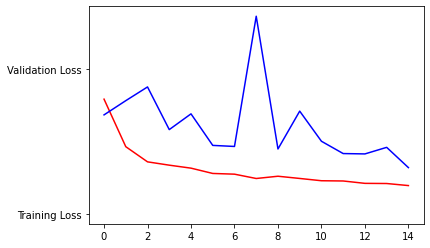

In [36]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

# Get number of epochs
epochs=range(len(acc)) 

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

***87,34% Accuracy on the test dataset is a very good result given that the model is very simple. In the next iteration I will rectify the number of epochs and rerun the training phase. According to the graphs above it may help in receiving better results.***

### Iteration 2nd
Number of epochs changed from 15 to 30. The same model structure and data generators are used.

In [58]:
model2 = create_model()

history2 = model2.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/30
82/82 [==============================] - 874s 10s/step - loss: 1.1699 - accuracy: 0.7199 - val_loss: 0.5441 - val_accuracy: 0.6923
Epoch 2/30
82/82 [==============================] - 903s 11s/step - loss: 0.4324 - accuracy: 0.7933 - val_loss: 0.8205 - val_accuracy: 0.5689
Epoch 3/30
82/82 [==============================] - 959s 12s/step - loss: 0.3755 - accuracy: 0.8286 - val_loss: 0.4783 - val_accuracy: 0.7933
Epoch 4/30
82/82 [==============================] - 797s 10s/step - loss: 0.3342 - accuracy: 0.8495 - val_loss: 0.4577 - val_accuracy: 0.7724
Epoch 5/30
82/82 [==============================] - 792s 10s/step - loss: 0.3057 - accuracy: 0.8622 - val_loss: 0.5622 - val_accuracy: 0.7019
Epoch 6/30
82/82 [==============================] - 791s 10s/step - loss: 0.2820 - accuracy: 0.8819 - val_loss: 0.5170 - val_accuracy: 0.7356
Epoch 7/30
82/82 [==============================] - 802s 10s/step - loss: 0.2775 - accuracy: 0.8905 - val_loss: 0.3824 - val_accuracy: 0.8221
Epoch 

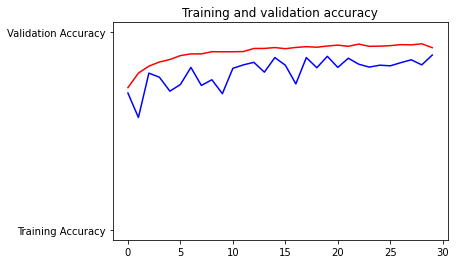

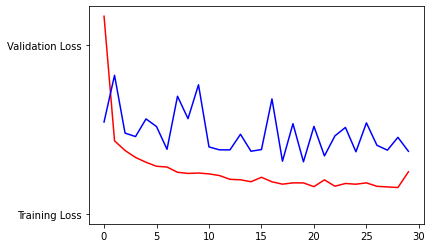

In [59]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

# Get number of epochs
epochs=range(len(acc)) 

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

***Despite the training took significantly more time, the validation accuracy hasn't grown as expected. As we can see, we reached the level of accuracy equals to 88,46%.***

Now let's take a look at the other possible solution - Transfer learning!

## 2. Transfer learning

In [60]:
def create_pre_trained_model():
    pre_trained_model = tf.keras.applications.ResNet152V2(
        weights='imagenet',
        input_shape=(300, 300, 3),
        include_top=False)

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    return pre_trained_model

In [61]:
pre_trained_model = create_pre_trained_model()

# Print the model summary
pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [62]:
def output_of_last_layer(pre_trained_model):
    """
    Gets the last layer output of a model

    Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

    Returns:
    last_output: output of the model's last layer
    """
    last_desired_layer = pre_trained_model.get_layer('conv4_block36_out')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)

    return last_output

In [63]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 10, 10, 1024)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 1024), dtype=tf.float32, name=None), name='conv4_block36_out/add:0', description="created by layer 'conv4_block36_out'")


In [64]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [65]:
def create_final_model(pre_trained_model, last_output):
    """
    Appends a custom model to a pre-trained model

    Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

    Returns:
    model: the combined model
    """
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer = RMSprop(learning_rate=0.0001), # smaller learning rate is being used to avoid the overfitting
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

    return model

In [66]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 148,199,937 total parameters in this model.
There are 104,859,649 trainable parameters in this model.


In [67]:
history3 = model.fit(train_generator,
                     validation_data = validation_generator,
                     epochs = 30,
                     verbose = 1)

Epoch 1/30
82/82 [==============================] - 1867s 22s/step - loss: 2.9637 - accuracy: 0.7805 - val_loss: 0.4644 - val_accuracy: 0.8670
Epoch 2/30
82/82 [==============================] - 1843s 22s/step - loss: 0.6037 - accuracy: 0.8589 - val_loss: 0.7423 - val_accuracy: 0.7388
Epoch 3/30
82/82 [==============================] - 1839s 22s/step - loss: 0.2938 - accuracy: 0.8942 - val_loss: 0.5756 - val_accuracy: 0.8141
Epoch 4/30
82/82 [==============================] - 1844s 22s/step - loss: 0.2746 - accuracy: 0.8978 - val_loss: 0.2843 - val_accuracy: 0.8942
Epoch 5/30
82/82 [==============================] - 1843s 22s/step - loss: 0.1975 - accuracy: 0.9229 - val_loss: 1.6084 - val_accuracy: 0.6747
Epoch 6/30
82/82 [==============================] - 1800s 22s/step - loss: 0.2046 - accuracy: 0.9222 - val_loss: 0.2322 - val_accuracy: 0.8990
Epoch 7/30
82/82 [==============================] - 1796s 22s/step - loss: 0.1783 - accuracy: 0.9329 - val_loss: 0.3314 - val_accuracy: 0.8702

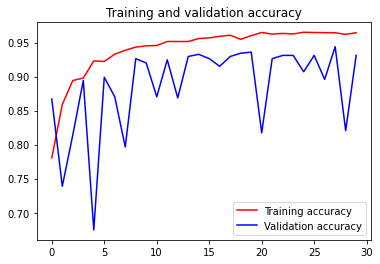

<Figure size 432x288 with 0 Axes>

In [68]:
# Plot the training and validation accuracies for each epoch

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

#### In this case we achieved results eguals to 93,11% of accuracy. That is a big increase in the accuracy, especially if we are taking into consideration the case that we are working on. The case that can have an impact on someone's life.